# VARIATIONAL AUTO ENCODER (VAE)

**This is implementation of VAE which force the network to ensure that samples are normally distributed over the space represented by the bottleneck.**

**Encoder output two n-dimensional (where n=128 is the number of dimensions in the latent space) vectors representing the mean and the standard devation. These Gaussians are sampled, and the samples are sent through the decoder.**

**KULLBACK-LIEBLER DIVERGENCE(KLD) Loss function is used, which bassically measure how one probability distribution is different from the second.**


**VAE network is trained on 700+ Indian car dataset collected through google images.**

In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session7-VAE/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session7-VAE/notebooks


In [4]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [6]:
import shutil
#shutil.rmtree('./logs/logs_MSE_96_Cur')

In [7]:
from pathlib import Path

# important folders used in this application

Path(f'logs').mkdir(exist_ok=True)

SOLUTION_LOG_DIR = f"logs/logs_MSE_96_Tanh_1"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [8]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=64,
    num_workers=6,
    epochs=1200,
    latent_dims=256, 
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [9]:
# dataset path where zip files are placed.
dataset_zip_file = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session6-gan/car_dataset.zip'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s7_dataset'

## Preparing Dataset

In [10]:
import utils.data_utils as dutils
import shutil

#if Path(root_dataset).exists():
#  shutil.rmtree(root_dataset)

In [11]:
# Extracting zipped dataset into colab internal memory
%%time

# Extracting dataset
if not Path(root_dataset).exists():
    print(f'Extracting car dataset images...')
    dutils.extract_dataset(fn=dataset_zip_file, dest=root_dataset)

# dataset size
dutils.get_dataset_count(root_dataset)
print('\n')


Total images in dataset: 704


CPU times: user 0 ns, sys: 866 µs, total: 866 µs
Wall time: 1.02 ms


In [12]:
# scan dataset and check if all images are in good state to read
dutils.scan_dataset(root_dataset, ['car'])

Scanning car images..: : 704it [00:05, 125.31it/s]


[]

# Prepare Data Transforms and DataLoader

In [13]:
from PIL import Image
import os, sys
import datetime

In [14]:
from utils.data_utils import prepare_dataset
dst_datadir = '/content/eva4p2_s7_dataset_working'

# Split train:test data
prepare_dataset(root_dataset, dst_datadir, valid_size=0.30)

Dataset already exist..


In [15]:
from utils.ImageAugmentationUtils import PyTorchImageAugmentation
IMAGE_DIM = (96, 96, 3)
#mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

imgAugmentation = PyTorchImageAugmentation(mean, std, size=IMAGE_DIM[0])
train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [16]:
from utils.data_utils import prepare_dataloader_ext
dataloader_args = dict(shuffle=True, batch_size=config_params["batch_size"], drop_last=True, num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)
train_loader, test_loader = prepare_dataloader_ext(train_dir=f'{dst_datadir}/train', 
                                               test_dir=f'{dst_datadir}/val', 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args)

print(f'Train size: {len(train_loader.dataset)}')
print(f'Test size: {len(test_loader.dataset)}')

Train size: 493
Test size: 211


In [17]:
# dataloader and image dimension
images, _ = next(iter(train_loader))
images.shape

torch.Size([64, 3, 96, 96])

# Visualize few training images

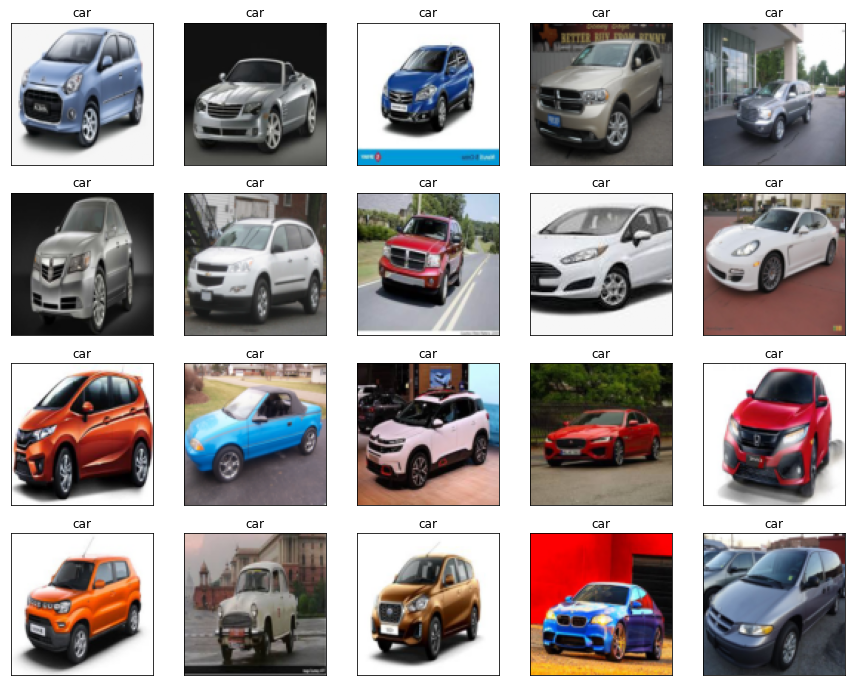

In [18]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, ['car'], None, None)

# visualize how image augmentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

# Variational Auto Encoder Network Model

In [19]:
MAX_EPOCH = config_params["epochs"]
BATCH_SIZE = config_params["batch_size"]
LATENT_DIMS = config_params["latent_dims"]

In [20]:
from models.vae_net import VAE

model = VAE(channels=IMAGE_DIM[-1], latent_dims=LATENT_DIMS).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 32602627


In [21]:
# specify loss function
#criterion = BCE = F.binary_cross_entropy()
#criterion = nn.L1Loss(size_average=False)
criterion = nn.MSELoss()

In [22]:
def loss_function(recon_x, x, mu, logvar):
    # how well do input x and output recon_x agree?
    bsize = recon_x.size(0)
    MSE = criterion(recon_x.view(bsize,-1), x.view(bsize,-1))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalise by same number of elements as in reconstruction
    KLD /= np.prod(recon_x.shape)

    loss = MSE + KLD

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return loss

In [23]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, StepLR, OneCycleLR

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
#lr_scheduler = CyclicLR(optimizer, base_lr=1e-6, max_lr=0.01, step_size_up=25, step_size_down=50, mode='triangular2', last_epoch=-1)
#lr_scheduler = OneCycleLR(optimizer,  max_lr=0.01,epochs=MAX_EPOCH, steps_per_epoch=len(train_loader))
lr_scheduler = None

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=(1/1.3456789), patience=10, threshold=0.0001)

In [24]:
def save_model(dec_model, epoch, loss):
    filename = f'{SAVED_MODELS_DIR}/vae_decoder_epoch{epoch}_{loss}_cuda.pt'
    torch.save(dec_model, filename)

def save_best_model(dec_model):
    filename = f'{SAVED_MODELS_DIR}/vae_decoder_best_cuda.pt'
    torch.save(dec_model, filename)

In [25]:
# store all losses
train_losses = []
test_losses = []
lr_values = []

def save_losses(trainloss, testloss):
    train_losses.append(trainloss)
    test_losses.append(testloss)

def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = Variable(data).to(device)
        data = data.to(device)
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)

        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # calculate the gradient of the loss w.r.t. the graph leaves i.e. input variables
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
     
    train_loss /= len(train_loader)
    #dt = datetime.datetime.now().strftime('%H:%M:%S')
    #print(f'====> Epoch: {epoch} Train loss: {train_loss:.8f} Time:{dt}')
    return train_loss


def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)

            test_loss += loss.item()
            if (epoch % SAVE_IMG_INTERVAL == 0) and (i==0):
              n = min(data.size(0), 8)
              # show the first 8 input original images with right below them the reconstructed output
              comparison = torch.cat([data[:n], recon_batch[:n]])
              filename = f'{SAVED_RESULTS_DIR}/reconstruction_' + str(epoch) + '.jpg'
              save_image(comparison.data.cpu(), filename, nrow=n)

        test_loss /= len(test_loader)
        #dt = datetime.datetime.now().strftime('%H:%M:%S')
        #print(f'====> Epoch: {epoch} Test loss : {test_loss:.8f}  Time:{dt}')
        return test_loss

In [26]:
print(f'MAX_EPOCH: {MAX_EPOCH}\nBATCH_SIZE: {BATCH_SIZE}\nLATENT_DIMS: {LATENT_DIMS}')

MAX_EPOCH: 1200
BATCH_SIZE: 64
LATENT_DIMS: 256


In [27]:
MODEL_NAME = 'VAE'
LOG_INTERVAL = 5 # epochs
SAVE_IMG_INTERVAL = 25 # epochs
SAVE_MODEL_INTERVAL = 60 # epochs
MAX_PATIENCE = 100 # quit if model didn't learn for last few epochs 

stop_cnt = 0
best_test_loss = 100 #some high value initially
#MAX_EPOCH = 1
for epoch in range(1, MAX_EPOCH + 1):

    train_loss = train(epoch)

    if(lr_scheduler != None):
      lr_scheduler.step()

    test_loss = test(epoch)

    if(reduceLr_scheduler != None):
      reduceLr_scheduler.step(test_loss)

    cur_lr = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_values.append(cur_lr)

    if epoch % LOG_INTERVAL == 0:
      dt = datetime.datetime.now().strftime('%H:%M:%S')
      print(f'====> Epoch: {epoch}/{MAX_EPOCH} Train Loss: {train_loss:.8f}, Test loss: {test_loss:.8f}, lr: {cur_lr:.10f} :: Time:{dt}')

    save_losses(train_loss, test_loss)

    stop_cnt += 1

    # save the model
    if test_loss < best_test_loss:
      stop_cnt = 0 # reset the counter
      best_test_loss = test_loss
      #save_best_model(model.decoder)

    if epoch % SAVE_MODEL_INTERVAL == 0:
      save_model(model.decoder, epoch, test_loss)
    
    if epoch % SAVE_IMG_INTERVAL == 0:
      # Generate 25 samples from random samples and see how model is performing
      model.eval()
      num_samples = 25
      sample = torch.randn(num_samples, LATENT_DIMS)
      sample = sample.to(device)
      sample = model.decoder(sample).cpu()
      model.train()

      # save out generate images, this will give you a visual idea of how well latent space can generate things that look like car
      #save_image(sample.data.view(num_samples, 1, 64, 64), f'{SAVED_RESULTS_DIR}/sample_' + str(epoch) + '.jpg')
      filename = f'{SAVED_RESULTS_DIR}/sample_' + str(epoch) + '.jpg'
      save_image(sample.data.cpu(), filename, nrow=int(np.sqrt(num_samples)))
    
    if stop_cnt > MAX_PATIENCE:
      print(f'stop training as loss is not improving further')
      break
    

====> Epoch: 5/1200 Train Loss: 0.07284666, Test loss: 0.06940867, lr: 0.0010000000 :: Time:18:37:30
====> Epoch: 10/1200 Train Loss: 0.06321432, Test loss: 0.05874690, lr: 0.0010000000 :: Time:18:37:55
====> Epoch: 15/1200 Train Loss: 0.05316601, Test loss: 0.05114782, lr: 0.0010000000 :: Time:18:38:20
====> Epoch: 20/1200 Train Loss: 0.05232144, Test loss: 0.05082692, lr: 0.0010000000 :: Time:18:38:45
====> Epoch: 25/1200 Train Loss: 0.05077090, Test loss: 0.04802047, lr: 0.0010000000 :: Time:18:39:10
====> Epoch: 30/1200 Train Loss: 0.04753362, Test loss: 0.04663357, lr: 0.0010000000 :: Time:18:39:36
====> Epoch: 35/1200 Train Loss: 0.04709379, Test loss: 0.04470371, lr: 0.0010000000 :: Time:18:40:01
====> Epoch: 40/1200 Train Loss: 0.04683412, Test loss: 0.04288422, lr: 0.0010000000 :: Time:18:40:26
====> Epoch: 45/1200 Train Loss: 0.04453900, Test loss: 0.04259580, lr: 0.0010000000 :: Time:18:40:52
====> Epoch: 50/1200 Train Loss: 0.04383414, Test loss: 0.04325839, lr: 0.001000000

In [28]:
torch.save(model.decoder, f'{SAVED_MODELS_DIR}/vae_final_decoder_cuda.pt')

In [29]:
def plot_losses(titlename, save_filename=None):
    start_idx = 0
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(train_losses)-start_idx

    legend_list = ['train_loss', 'test_loss']

    # plot losses
    axs.plot(range(0,x_size), train_losses[start_idx:])
    axs.plot(range(0,x_size), test_losses[start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Losses')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

def plot_lr(titlename, save_filename=None):
    start_idx = 0
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(lr_values)-start_idx

    legend_list = ['lr']

    # plot losses
    axs.plot(range(0,x_size), lr_values[start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('LR')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

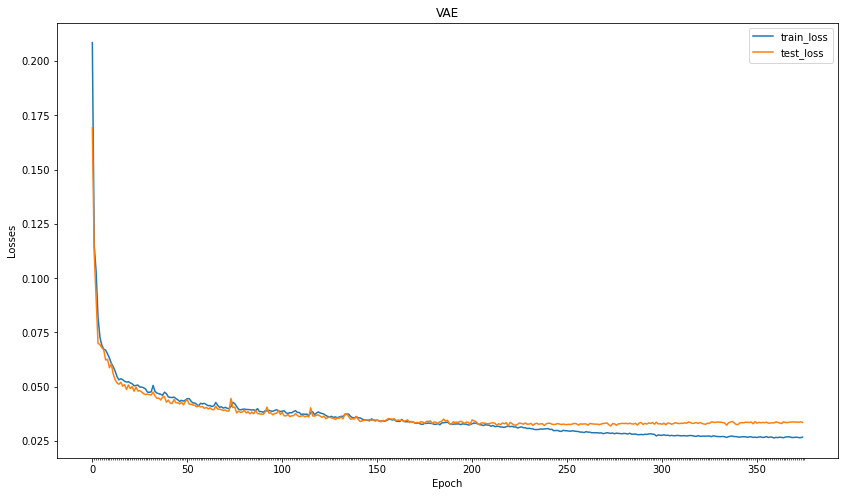

In [30]:
plot_losses(MODEL_NAME, f'{PLOT_DIR}/losses_plot.jpg' )

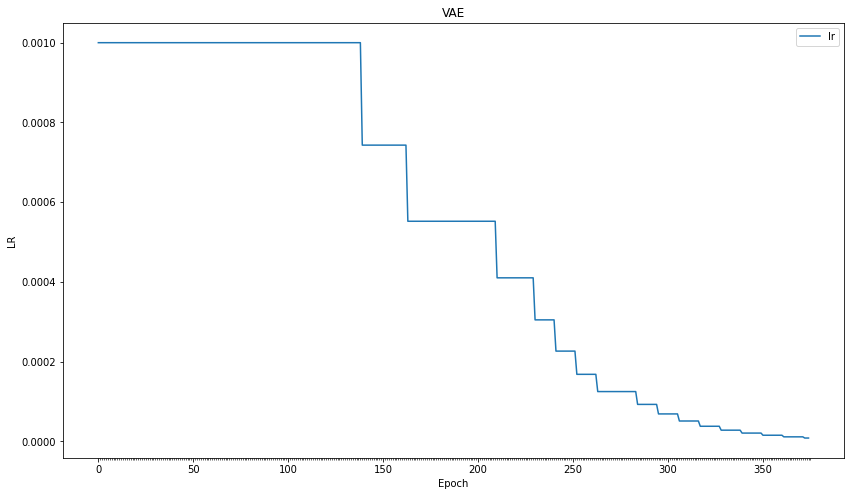

In [31]:
plot_lr(MODEL_NAME, f'{PLOT_DIR}/lr_plot.jpg' )

In [32]:
decoder_model = torch.load(f'{SAVED_MODELS_DIR}/vae_final_decoder_cuda.pt')
#decoder_model = torch.load(f'{SAVED_MODELS_DIR}/decoder_epoch1050_0.001148563549275647_cuda.pt')

In [33]:
def get_sample_image(device, decoder, latent_dims, n_samples=25):
    n_rows = int(np.sqrt(n_samples))
    sample = torch.randn(n_samples, latent_dims)
    sample = sample.to(device)
    sample = decoder(sample).cpu()
    sample = torch.cat([torch.cat([sample[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    sample = np.transpose(sample.detach().numpy(),[1,2,0])
    sample = sample.astype(np.float)
    return np.clip(sample,0,1)

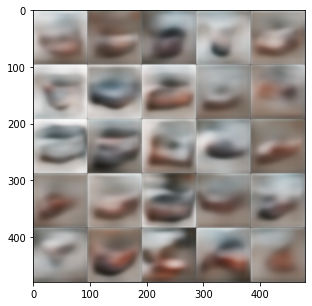

In [34]:
decoder_model = decoder_model.to(device)
decoder_model.eval()
fake_images = get_sample_image(device, decoder_model, latent_dims=LATENT_DIMS, n_samples=25)

fig = plt.figure(figsize=(5, 5))
plt.imshow(fake_images)

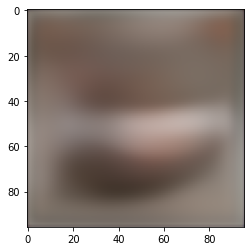

In [35]:
# Fake Image
idx = [0,1]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
plt.imshow(fake_images[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

# Interpolation

In [36]:
a, b = torch.randn(LATENT_DIMS), torch.randn(LATENT_DIMS)
z = torch.tensor([np.linspace(a[i], b[i], num=10) for i in range(LATENT_DIMS)], dtype=torch.float32).to(device)
z = torch.transpose(z, 0, 1)
z.shape

torch.Size([10, 256])

In [37]:
imgs = decoder_model(z).cpu()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs = np.transpose(imgs.detach().numpy(),[1,2,0])
imgs.shape

(96, 960, 3)

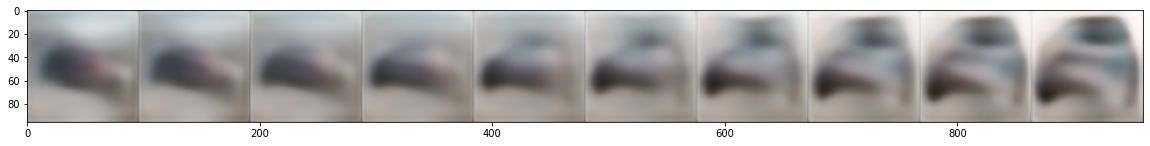

In [38]:
fig = plt.figure(figsize=(20, 3))
plt.imshow(imgs)